In [139]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [244]:
from fastai.conv_learner import *

In [321]:
PATH1 = "D:/FAST.Ai/Idea/OCR/"

In [246]:
os.listdir(PATH1)

['data',
 'models',
 'New folder',
 'New Microsoft Excel Worksheet.xlsx',
 'ocr.csv',
 'ocr.xlsx',
 'tmp',
 '~$ocr.xlsx']

In [247]:
from fastai.plots import *

In [248]:
from planet import *

In [266]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [267]:
metrics=[f2]
f_model = resnet34

In [268]:
label_csv = f'{PATH1}ocr.csv'

In [269]:
n = len(list(open(label_csv))) - 1

In [270]:
n

5

In [271]:
val_idxs = get_cv_idxs(n)

In [272]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    # transforms_top_down means full set of possible transformasions  
    return ImageClassifierData.from_csv(PATH1, 'data', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs)#, test_name='test-jpg')

In [273]:
sz = 64
data = get_data(sz)

In [274]:
fn = PATH1 + data.trn_ds.fnames[0]

In [275]:
fn

'D:/FAST.Ai/Idea/OCR/data\\20cce081f833c47cc58ca579f9bc1cd7eb8189a7.jpg'

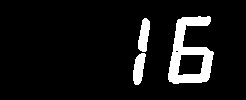

In [276]:
img = PIL.Image.open(fn); img

In [277]:
img.size

(246, 100)

In [278]:
it = iter(data.val_dl)

In [279]:
x,y = next(it)

In [280]:
y


 1  0  0  0
[torch.FloatTensor of size 1x4]

In [281]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


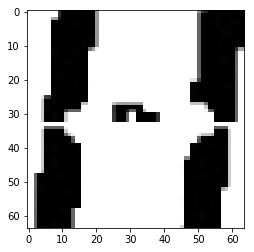

In [282]:
plt.imshow(data.val_ds.denorm(to_np(x))[0] * 1.4)

In [283]:
list(zip(y[0],data.classes))

[(1.0, '0'), (0.0, '1'), (0.0, '10'), (0.0, '6')]

In [206]:
learn = ConvLearner.pretrained(f_model,data,metrics = metrics)

epoch      trn_loss   val_loss   f2                                                                                    
    0      1.046528   0.801613   0.555556  



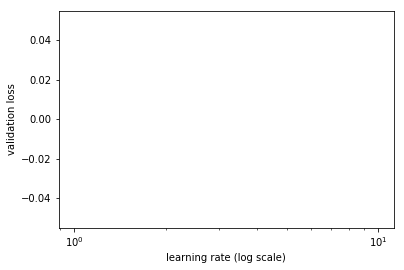

In [207]:
lrf = learn.lr_find()
learn.sched.plot()

In [98]:
lr = 0.2

In [99]:
learn.fit(lr,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.979422   0.742429   0.555556  
    1      0.892775   0.734385   0.555556                                                                              
    2      0.794796   0.455336   0.625                                                                                 
    3      0.745244   0.476076   0.555556                                                                              
    4      0.721367   0.185629   1.0                                                                                   
    5      0.663115   0.201498   0.714286                                                                              
    6      0.597608   0.112555   1.0                                                                                   



[array([0.11255]), 1.0]

# reading numbers from folders and turnig them to CSV

In [285]:
PATH=Path('D:/FAST.Ai/Idea/Seven-Segment-OCR-master/Datasets_Eleven')

In [474]:
for j in range(10,100,10):
    print(j)

10
20
30
40
50
60
70
80
90


In [475]:
for j in range(100,1000,100):
    print(j)

100
200
300
400
500
600
700
800
900


In [286]:
CLASSES = ['0','1','2', '3','4', '5','6', '7','8', '9']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname)
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH)

In [301]:
name_trn_texts = []
for i in range(len(trn_texts)):
    name_trn_texts.append(str(trn_texts[i]).split("\\")[-1].split(".")[0])

In [304]:
name_trn_texts[:5]

['01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 2',
 '01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 3',
 '02b292a500dfb9192379fe830534cfd8b38f003f - 2',
 '02b292a500dfb9192379fe830534cfd8b38f003f - 3',
 '04dc6be4599a36518fcb26bf9355508d57ce6887 - 3']

In [294]:
str(trn_texts[0]).split("\\")[-1].split(".")[0]

'01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 2'

In [306]:
len(name_trn_texts),len(trn_labels)

(223, 223)

In [307]:
col_names = ['fname','labels']

In [309]:
np.random.seed(40)
trn_idx = np.random.permutation(len(trn_texts))

In [311]:
trn_texts =trn_texts[trn_idx]
trn_labels = trn_labels[trn_idx]

In [316]:
df_trn = pd.DataFrame({'fname':name_trn_texts, 'labels':trn_labels}, columns=col_names)

In [318]:
df_trn.head()

fname  labels
0  01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 2       6
1  01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 3       0
2  02b292a500dfb9192379fe830534cfd8b38f003f - 2       0
3  02b292a500dfb9192379fe830534cfd8b38f003f - 3       3
4  04dc6be4599a36518fcb26bf9355508d57ce6887 - 3       0

In [322]:
df_trn.to_csv(PATH1+'train.csv', header=False, index=False)

# doing model again with more data

In [443]:
metrics=[f2]
f_model = resnet34

In [444]:
label_csv = f'{PATH1}train.csv'

In [445]:
n = len(list(open(label_csv)))

In [446]:
n

223

In [447]:
val_idxs = get_cv_idxs(n)

In [448]:
def get_data(sz , bs):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1)
    # transforms_top_down means full set of possible transformasions  
    return ImageClassifierData.from_csv(PATH1, 'data', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs , bs=bs)#, test_name='test-jpg')

In [525]:
sz = 64
data = get_data(sz , bs = 64)

In [526]:
fn = PATH1 + data.trn_ds.fnames[0]

In [527]:
fn

'D:/FAST.Ai/Idea/OCR/data\\01cbb4e0a7fd47251fc1340aa9df876ebd41a0c2 - 3.jpg'

In [528]:
img = PIL.Image.open(fn); img

In [529]:
img.size

(28, 44)

In [530]:
it = iter(data.val_dl)

In [531]:
x,y = next(it)

In [532]:
y


    0     1     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     1     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0
    0    

In [533]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


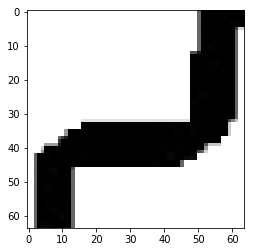

In [534]:
plt.imshow(data.val_ds.denorm(to_np(x))[26] * 1.4)

In [467]:
data.classes

['', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [468]:
list(zip(y[0],data.classes))

[(0.0, ''),
 (1.0, '0'),
 (0.0, '1'),
 (0.0, '2'),
 (0.0, '3'),
 (0.0, '4'),
 (0.0, '5'),
 (0.0, '6'),
 (0.0, '7'),
 (0.0, '8'),
 (0.0, '9')]

In [469]:
learn = ConvLearner.pretrained(f_model,data,metrics = metrics)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.854284   0.696591   0.333333  



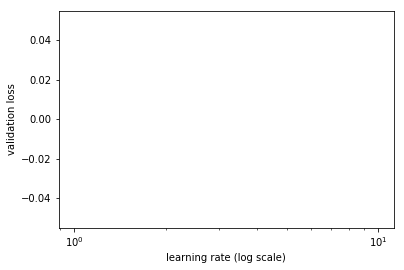

In [470]:
lrf = learn.lr_find()
learn.sched.plot()

In [471]:
lr = 0.2

In [472]:
learn.fit(lr,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.81621    0.704349   0.318723  
    1      0.79561    0.611462   0.325758                                                                              
    2      0.753613   0.57373    0.32684                                                                               
    3      0.713313   0.44539    0.334749                                                                              
    4      0.660779   0.3625     0.433146                                                                              
    5      0.609966   0.331974   0.467803                                                                              
    6      0.568601   0.325715   0.461174                                                                              



[array([0.32571]), 0.46117424242424243]

In [476]:
lrs = np.array([lr/9,lr/3,lr])

In [477]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.387238   0.315017   0.452611  
    1      0.379385   0.293509   0.457759                                                                              
    2      0.364676   0.291616   0.440255                                                                              
    3      0.350164   0.288877   0.463925                                                                              
    4      0.340589   0.286873   0.42307                                                                               
    5      0.330408   0.288825   0.4136                                                                                
    6      0.323771   0.279147   0.446429                                                                              



[array([0.27915]), 0.4464285714285715]

In [478]:
learn.save(f'{sz}')

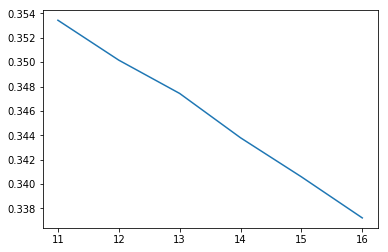

In [479]:
learn.sched.plot_loss()

In [480]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [489]:
preds.shape

(44, 11)

In [490]:
preds

array([[0.03104, 0.26702, 0.09012, 0.12829, 0.13665, 0.03581, 0.09719, 0.1597 , 0.04527, 0.04293, 0.06707],
       [0.0333 , 0.38581, 0.11073, 0.18697, 0.073  , 0.06364, 0.07009, 0.13096, 0.07722, 0.08236, 0.05694],
       [0.02593, 0.35972, 0.06782, 0.1136 , 0.08347, 0.03693, 0.08905, 0.10349, 0.03992, 0.04722, 0.03212],
       [0.03313, 0.16345, 0.03806, 0.13587, 0.13649, 0.01415, 0.12461, 0.1288 , 0.02417, 0.01909, 0.07872],
       [0.02844, 0.31311, 0.08406, 0.0948 , 0.06078, 0.06052, 0.08184, 0.127  , 0.0394 , 0.04532, 0.03253],
       [0.03727, 0.33486, 0.07604, 0.09454, 0.08673, 0.05791, 0.05848, 0.1054 , 0.04407, 0.06765, 0.04435],
       [0.04266, 0.36143, 0.07875, 0.12515, 0.06553, 0.07281, 0.04553, 0.10606, 0.05241, 0.05615, 0.04095],
       [0.0416 , 0.32814, 0.09809, 0.11951, 0.11477, 0.05552, 0.08656, 0.12634, 0.05472, 0.07486, 0.04546],
       [0.0212 , 0.29278, 0.06538, 0.1746 , 0.14773, 0.04058, 0.08012, 0.13518, 0.03167, 0.05199, 0.04043],
       [0.023  , 0.30348, 0.

In [497]:
one_number_preds = np.argmax(preds,axis=1)
one_number_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 7, 1, 1, 1], dtype=int64)

In [495]:
one_number_y = np.argmax(y,axis=1)
one_number_y

array([ 1,  1,  3,  8,  5,  1,  1,  3,  1,  5,  1,  1,  1,  1,  3,  1,  2,  4,  1,  3,  1,  3,  3,  3,  6,
        1,  1,  6,  2,  1,  1,  1,  3,  3,  5,  6,  1,  3,  2,  1,  1,  7,  1, 10], dtype=int64)

# accuracy

In [499]:
np.mean(one_number_preds == one_number_y)

0.4090909090909091

# doing model again with a bit more data

In [ ]:
mean of accuracy

In [ ]:
showing augmentation

In [ ]:
change num of classes to 30 

In [ ]:
edit final accuracy measuring 

In [ ]:
multi lable , writing in csv 

In [ ]:
glucometer , with learn.set_data(get_data(sz))